In [ ]:
import os
import numpy as np
import pandas as pd
import random

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score

In [ ]:
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns

## **Data Preprocessing**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

basicpath = '/content/drive/MyDrive/'

Mounted at /content/drive


In [ ]:
path = basicpath + 'Colab Notebooks'

In [ ]:
gen_f = 'labeled_gen_url.csv'
mal_f = 'labeled_mal_url.csv'

data_gen = pd.read_csv(os.path.join(path, gen_f))
data_mal = pd.read_csv(os.path.join(path, mal_f))

In [ ]:
# Combine malicious & benign URLs into one dataset
data_file = pd.concat([data_gen, data_mal])

In [ ]:
data_file

,url,label
0,https://www.piuvivi.com/rss-feed.html,good
1,https://www.unitedglobalsim.com,good
2,https://spalwart.com/information/general-infor...,good
3,http://www.celticfc.net/matchday,good
4,http://www.etawasul.net/?page=svenska,good
...,...,...
158076,http://manageaccountpageid79325923-usersetting...,bad
158077,http://especially1.dyndns.dk/htmmr/Office/,bad
158078,http://www.iintednx.com/check/apple/Congratula...,bad
158079,https://newsknife.fun/store.steampowered.com/l...,bad


In [ ]:
# Shuffle dataset randomly
shuffled_file = data_file.sample(frac=1)

In [ ]:
shuffled_file

,url,label
155218,http://paczkaa24.com/094UG9s6/hdYflw0,bad
151314,https://bouldermedicalweightloss.com/mt/q.html,bad
140301,https://www.bigscribe.com/contact-us/,good
259735,https://www.xujan.com/video/104504/txun-axchka...,good
422112,https://www.phoenixhouse.org/about-us/careers/,good
...,...,...
309653,http://info.mannapro.com/equine,good
129266,http://korea.nabo.go.kr/,good
25143,http://uutvdome.ru/publ/12,good
378394,https://avmajournals.avma.org/loi/javma/,good


In [ ]:
sf = pd.DataFrame(shuffled_file)
col = ['label', 'url']
sf = sf[col]

# Data cleaning (remove duplicates)
sf.columns = ['label', 'url']
sf['category_id'] = sf['label'].factorize()[0]
category_id_sf = sf[['label', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id1 = dict(category_id_sf.values)
id_to_category1 = dict(category_id_sf[['category_id', 'label']].values)

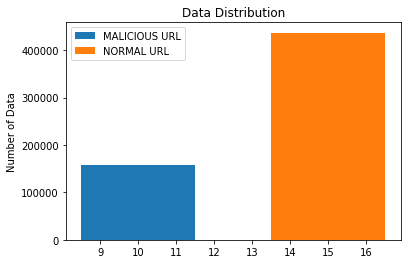

In [ ]:
%matplotlib inline
MAL_len = sf[sf['label'] == 'bad'].shape[0]
BEN_len = sf[sf['label'] == 'good'].shape[0]
plt.bar(10, MAL_len, 3, label="MALICIOUS URL")
plt.bar(15, BEN_len, 3, label="NORMAL URL")
plt.legend()
plt.ylabel('Number of Data')
plt.title('Data Distribution')
plt.show()

In [ ]:
print("Malicious URLs: {}".format(MAL_len))
print("Genuine URLs: {}".format(BEN_len))

Malicious URLs: 158081
Genuine URLs: 436725


In [ ]:
# Tokenizer function
def myTokenizer(input):
    tokens_by_backslash = str(input.encode('utf-8')).split('/') # generate tokens after splitting by slash
    output=[]
    for i in tokens_by_backslash:
        tokens = str(i).split('-') # generate tokens after splitting by hyphen
        tokens_by_dot = []
        for j in range(0,len(tokens)):
            temp = str(tokens[j]).split('.') # generate tokens after splitting by dot
            tokens_by_dot += temp
        output = output + tokens + tokens_by_dot
    output = list(set(output)) # remove redundant tokens
    if 'com' in output:
        output.remove('com') # remove ".com" token (redundant)
    return output

In [ ]:
# Define vectorizer
vectorizer = TfidfVectorizer(tokenizer=myTokenizer)

In [ ]:
# Tokenize & vectorize URLs
features = vectorizer.fit_transform(sf.url)
labels = sf.label
print("Number of features extracted: {}".format(features.shape[1]))

Number of features extracted: 1418106


In [ ]:
x = features
y = labels

# Split dataset into training & test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

## **Model Training**

### **Logistic Regression**

In [ ]:
# Create logistic regression classifier
log = LogisticRegression()

# Train model using training dataset
log.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [ ]:
# Test model with test dataset
%timeit log.predict(x_test)
y_log = log.predict(x_test)

10 loops, best of 5: 17.8 ms per loop


In [ ]:
train_score = log.score(x_train, y_train)
test_score = log.score(x_test, y_test)

print('Accuracy for:')
print('Training data: {}'.format(train_score))
print('Test data: {}'.format(test_score))

Accuracy for:
Training data: 0.9684287287430334
Test data: 0.9565743682856711


### **Confusion Matrix**

Text(0.5, 15.0, 'Predicted')

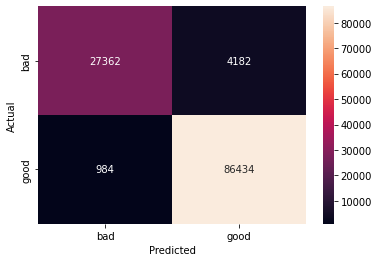

In [ ]:
conf_mat = confusion_matrix(y_test, y_log)
sns.heatmap(conf_mat, annot=True, fmt='d',
xticklabels=category_id_sf.label.values, yticklabels=category_id_sf.label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [ ]:
print('Number of URLs in test set: {}'.format(x_test.shape[0]))

Number of URLs in test set: 118962


## **Prediction**

In [ ]:
# Load a different dataset to test trained model
file = 'data.csv'
df = pd.read_csv(os.path.join(path, file), index_col = None)

In [ ]:
df.head(10)

,url,label
0,diaryofagameaddict.com,bad
1,espdesign.com.au,bad
2,iamagameaddict.com,bad
3,kalantzis.net,bad
4,slightlyoffcenter.net,bad
5,toddscarwash.com,bad
6,tubemoviez.com,bad
7,ipl.hk,bad
8,crackspider.us/toolbar/install.php?pack=exe,bad
9,pos-kupang.com/,bad


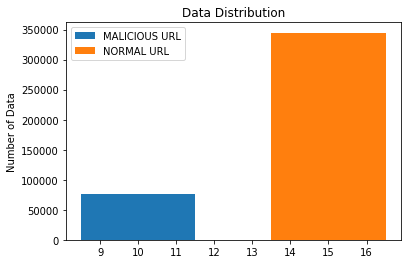

In [ ]:
%matplotlib inline
MAL_len = df[df['label'] == 'bad'].shape[0]
BEN_len = df[df['label'] == 'good'].shape[0]
plt.bar(10, MAL_len, 3, label="MALICIOUS URL")
plt.bar(15, BEN_len, 3, label="NORMAL URL")
plt.legend()
plt.ylabel('Number of Data')
plt.title('Data Distribution')
plt.show()

In [ ]:
df = pd.DataFrame(df)
col = ['label','url']
df = df[col]

# Data cleaning (remove duplicates)
df = df[pd.notnull(df['url'])]
df.columns = ['label', 'url']
df['category_id'] = df['label'].factorize()[0]
category_id_df = df[['label', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'label']].values)

In [ ]:
# Tokenize & vectorize URLs
new_features = vectorizer.transform(df.url)
new_labels = df.label
print("Number of features extracted: {}".format(new_features.shape[1]))

Number of features extracted: 1418106


In [ ]:
new_x = new_features
new_y = new_labels

In [ ]:
# Predict labels of URLs using trained model
%timeit log.predict(new_x)

10 loops, best of 5: 26.1 ms per loop


In [ ]:
pred_score = log.score(new_x, new_y)

print('Accuracy: {}'.format(pred_score))

Accuracy: 0.831795349899159
